# Τεχνικές Εξόρυξης Δεδομένων
### Εργασία 2, Εαρινό Εξάμηνο 2021

**Θεμιστοκλής Σωτηρόπουλος 1115201400197**

**Δημήτριος Μπέρος 1115201600269**

# Προετοιμασία: **1. Προεπεξεργασία/ Καθάρισμα**



In [2]:
!pip install --upgrade gensim
!pip install --upgrade wordcloud
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import pandas as pd
import random
import numpy as np
import re
import random
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score
from google.colab import drive
import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import gensim.downloader as api
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, accuracy_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
nltk.download('stopwords')
drive.mount('/content/gdrive',force_remount=True)

Requirement already up-to-date: gensim in /usr/local/lib/python3.7/dist-packages (4.0.1)
Requirement already up-to-date: wordcloud in /usr/local/lib/python3.7/dist-packages (1.8.1)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Mounted at /content/gdrive


*Διάβασμα αρχείου Fake*

In [3]:
fake=pd.read_csv('/content/gdrive/MyDrive/DataMining/Project2/NewsDataset/Fake.csv')

*Διάβασμα αρχείου True*

In [4]:
true=pd.read_csv('/content/gdrive/MyDrive/DataMining/Project2/NewsDataset/True.csv')

*Σε αυτό το σημείο απλά αφαιρέσαμε τα rows με null τιμές. Ο καθαρισμός του κειμένου γίνεται παρακάτω*

In [5]:
fakeNN=fake.dropna()
trueNN=true.dropna()

# **2.  Μελέτη των δεδομένων.**

*α. Ο τίτλος καθορίζει αρκετά το περιεχόμενο ενός άρθρου. Προσπαθήστε να
οπτικοποιήστε τους τίτλους των fake και των non-fake news έτσι ώστε να μπορεί
κάποιος να εντοπίσει τα κεντρικά θέματα τα οποία διαπραγματεύονται τα άρθρα.*

*Παίρνουμε από τα Dataframes των Fake και True, τις στήλες με τους τίτλους. Χωρίζουμε τους τίτλους ανά λέξη και αφαιρούμε τα stopwords, τα σημεία στίξης και σύμβολα και τους αποθηκεύουμε σε λίστα από λίστες.*

In [6]:
fakeTitles = fakeNN['title']
trueTitles = trueNN['title']

fakeTokens = [title.lower().split() for title in fakeTitles]
trueTokens = [title.lower().split() for title in trueTitles]


stop_words = list(stopwords.words('english'))

fakeTokens2 = []
trueTokens2 = []

for i in range(len(fakeTokens)):
    temp = []
    for word in fakeTokens[i]:
        if word not in stop_words:
            word = re.sub(r"[^\w'.\s]", '', word)
            if len(word) > 1:
                temp.append(word)
    fakeTokens2.append(temp)


for i in range(len(trueTokens)):
    temp = []
    for word in trueTokens[i]:
        if word not in stop_words:
            word = re.sub(r"[^\w'.\s]", '', word)
            if len(word) > 1:
                temp.append(word)
    trueTokens2.append(temp)

*Με βάση τις παραπάνω λίστες δημιουργούμε δύο μοντέλα word2vec, χτίζουμε το λεξιλόγιο τους και τα κάνουμε train.*

In [7]:
w2vmodelFake = Word2Vec(fakeTokens2,vector_size=50,seed=32,
    negative=5,sg=0,min_count=1,window=1)

w2vmodelFake.build_vocab(fakeTokens2)  # prepare the model vocabulary

w2vmodelFake.train(fakeTokens2, total_examples=w2vmodelFake.corpus_count, epochs=5) # train the model

w2vmodelTrue = Word2Vec(trueTokens2,vector_size=50,seed=32,
    negative=5,sg=0,min_count=1,window=1)

w2vmodelTrue.build_vocab(trueTokens2)  # prepare the model vocabulary

w2vmodelTrue.train(trueTokens2, total_examples=w2vmodelTrue.corpus_count, epochs=5) # train the model

(799834, 862790)

*Την παρακάτω συνάρτηση την έχουμε πάρει από το Notebook Small_Word_Embeddings_with_Gensim των σημειώσεων του μαθήματος. Κάναμε μερικές τροποποιήσεις έτσι ώστε να λειτουργεί σωστά με την ενημερωμένη έκδοση του word2vec καθώς και με τα δεδομένα μας.*

In [8]:
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.wv.index_to_key), sample)
        else:
            words = [ word for word in model.wv.index_to_key]
        
    word_vectors = np.array([model.wv[w] for w in words])
    print(word_vectors.shape)

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(20,20))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)
    plt.show()

*Στη λίστα που είναι αποθηκευμένο το λεξιλόγιο του κάθε μοντέλου, εμφανίζονται με φθίνουσα σειρά οι πιο συχνά εμφανιζόμενες λέξεις. Για λόγους αποδοτικότητας και πολυπλοκότητας του αλγορίθμου, επιλέξαμε να εμφανίσουμε τις Top 500 από τις οποίες αφαιρέσαμε τις διπλότυπες.*

In [9]:
tempFake = w2vmodelFake.wv.index_to_key[:500]
topFake = list(dict.fromkeys(tempFake))

In [10]:
tempTrue = w2vmodelTrue.wv.index_to_key[:500]
topTrue = list(dict.fromkeys(tempTrue))

*Και για τις δύο κατηγορίες άρθρων, φτιάχνουμε μία λίστα από tuples με πρώτη τιμή τη λέξη και δεύτερη τιμή τα Vectors των τιμών τους στο μοντέλο*

In [11]:
vlistFake = []
words_filter_fake = []

for word in topFake:
        if word in w2vmodelFake.wv.index_to_key:
            vlistFake.append(w2vmodelFake.wv[word])
            words_filter_fake.append(word)

word_vec_zip_fake = list(zip(words_filter_fake, vlistFake))

In [12]:
vlistTrue = []
words_filter_true = []

for word in topTrue:
        if word in w2vmodelTrue.wv.index_to_key:
            vlistTrue.append(w2vmodelTrue.wv[word])
            words_filter_true.append(word)

word_vec_zip_true = list(zip(words_filter_true, vlistTrue))

*Δημιουργούμε Dataframes με τις λίστες αυτές*

In [13]:
dfFake = pd.DataFrame(data = word_vec_zip_fake, columns=['word', 'value'])
dfTrue = pd.DataFrame(data = word_vec_zip_true, columns=['word', 'value'])

*Εμφάνιση αποτελεσμάτων για τα Fake news.*

(500, 50)


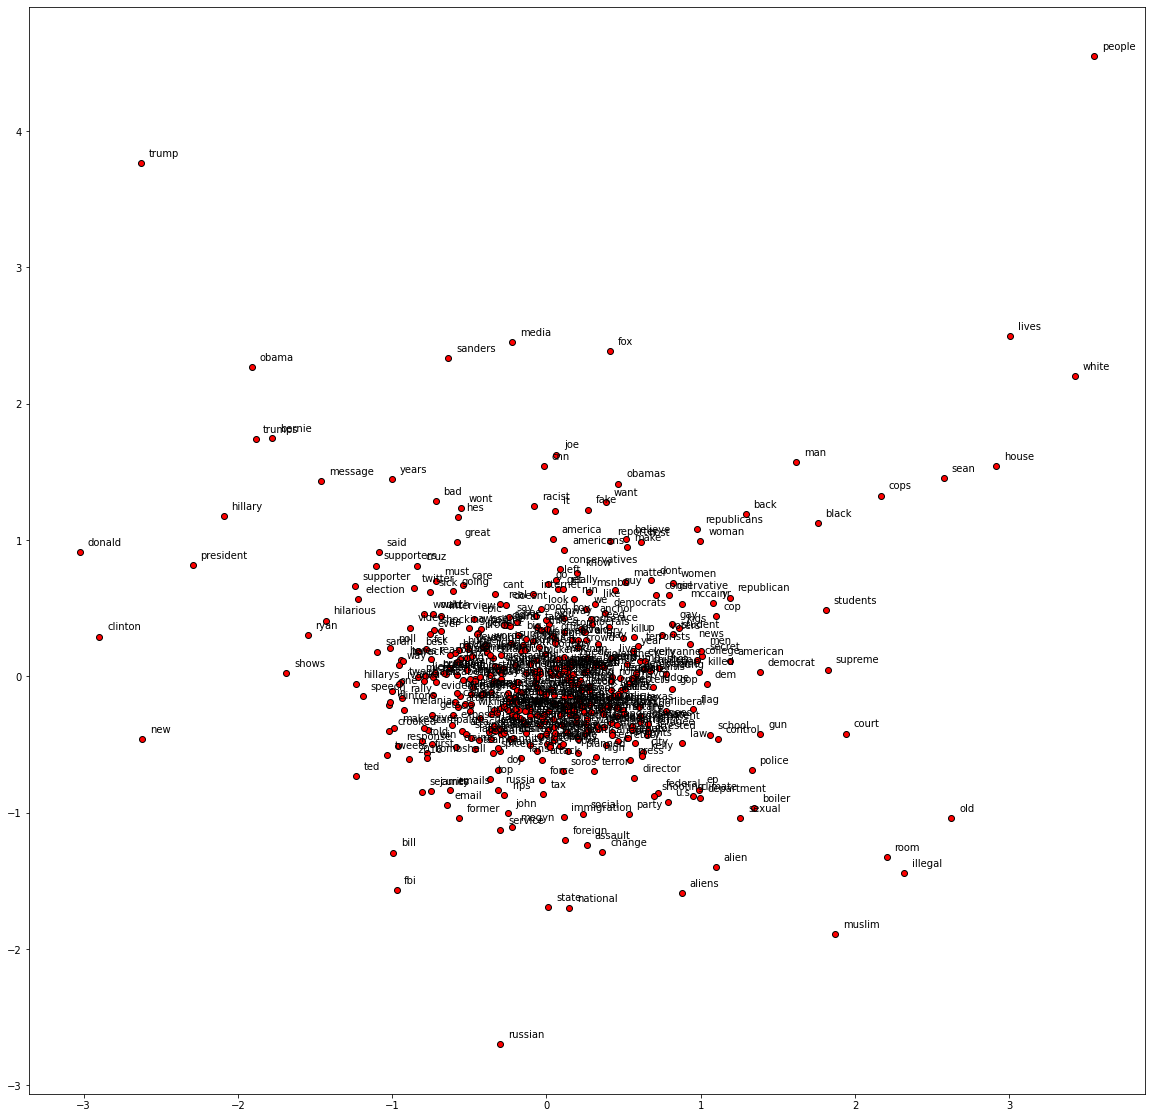

In [14]:
wFake = dfFake['word']
words = [w for w in wFake]
  
display_pca_scatterplot(w2vmodelFake, words)

*Εμφάνιση αποτελεσμάτων για True*

(500, 50)


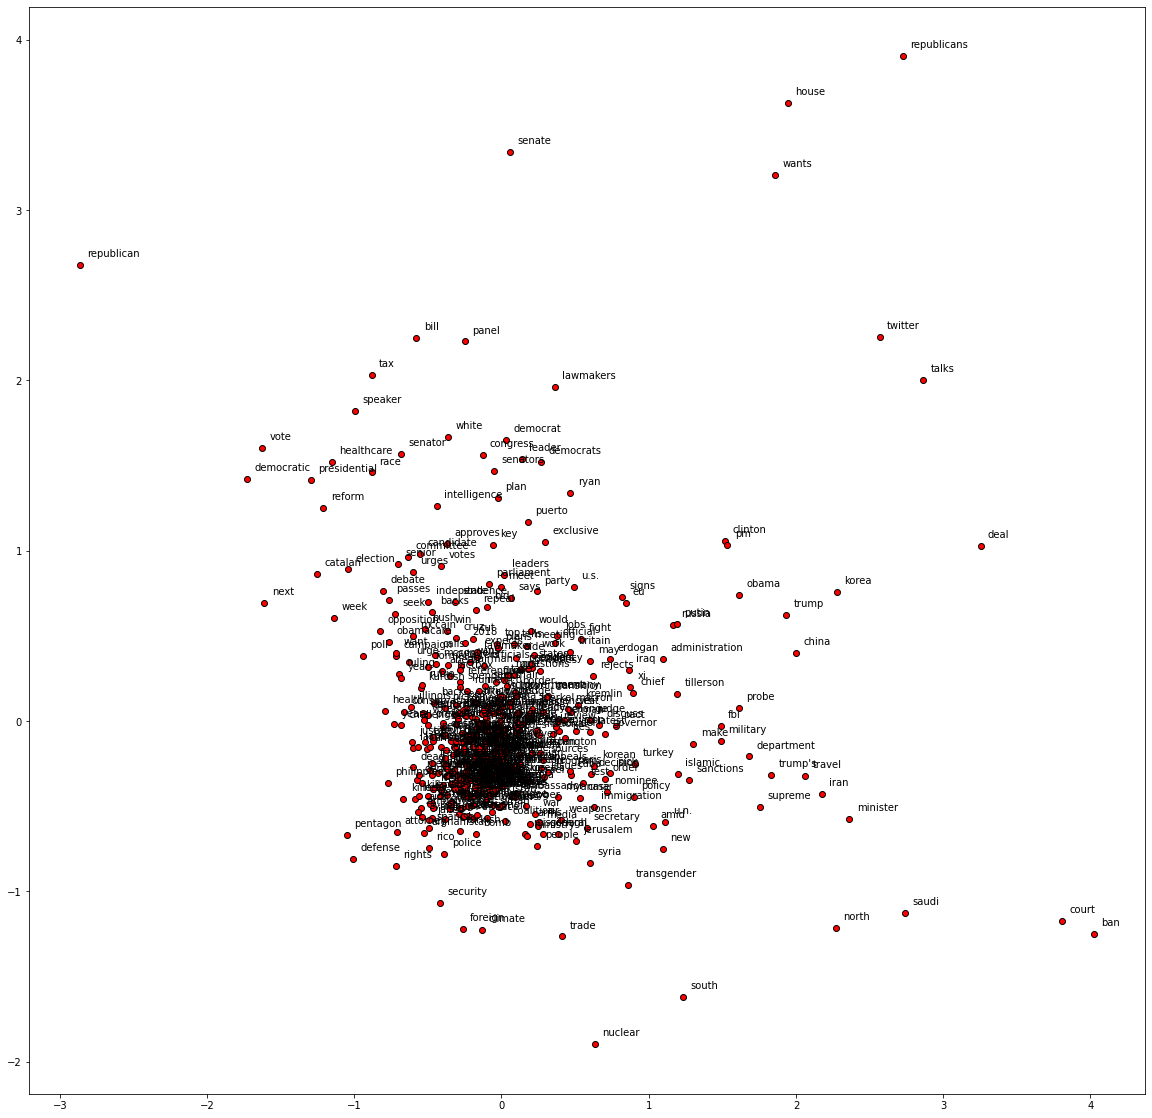

In [15]:
wTrue = dfTrue['word']
words = [w for w in wTrue]
  
display_pca_scatterplot(w2vmodelTrue, words)

*Ως δεύτερη και πιο εμφανίσιμη οπτικοποίηση, δημιουργήσαμε wordclouds και για τις δύο κατηγορίες*

*Fake*

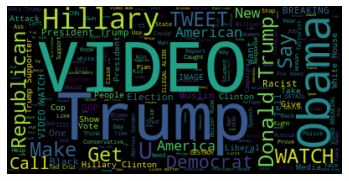

In [16]:
text = " ".join(n for n in fakeNN['title'])
wordcloud = WordCloud(stopwords=stop_words).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.show()

*True*

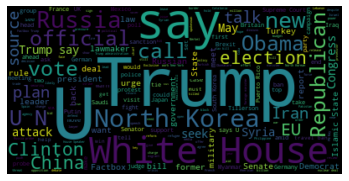

In [17]:
text2 = " ".join(n for n in trueNN['title'])
wordcloud2 = WordCloud(stopwords=stop_words).generate(text2)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")

plt.show()

Μέσος όρος χαρακτήρων στους τίτλους των Fake: 95.19798986414548
Μέσος όρος χαρακτήρων στους τίτλους των True: 65.66783396367371


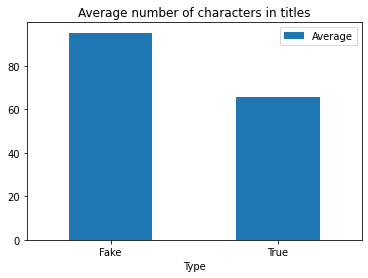

In [18]:
avgChar = len(text) / len(fakeNN.index)
avgChar2 = len(text2) / len(trueNN.index)

print("Μέσος όρος χαρακτήρων στους τίτλους των Fake:", avgChar)
print("Μέσος όρος χαρακτήρων στους τίτλους των True:", avgChar2)

avgDict = {'Fake': avgChar, 'True': avgChar2}
avgDF = pd.DataFrame.from_dict(avgDict, orient='index', columns=['Average'])

avgDF.plot.bar(rot=0)
plt.xlabel('Type')
plt.title('Average number of characters in titles')
plt.show()

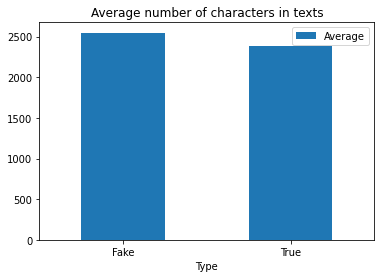

In [19]:
allTextsFake = " ".join(n for n in fakeNN['text'])
allTextsTrue = " ".join(n for n in trueNN['text'])

avgTextFake = len(allTextsFake) / len(fakeNN.index)
avgTextTrue = len(allTextsTrue) / len(trueNN.index)

avgText = {'Fake': avgTextFake, 'True': avgTextTrue}

avgTextDF = pd.DataFrame.from_dict(avgText, orient='index', columns=['Average'])

avgTextDF.plot.bar(rot=0)
plt.xlabel('Type')
plt.title('Average number of characters in texts')
plt.show()

*γ. Σχεδιάστε την κατανομή του αριθμού των λέξεων για τη στήλη title και για τη στήλη
text (και για τα δύο αρχεία)*

*Η διαφορά των νούμερων ήταν πολύ μεγάλη, δε βρήκαμε καλύτερο τρόπο να τα οπτικοποιήσουμε. Απλώς απενεργοποιήσαμε το scientific format, έτσι ώστε να νούμερα να εμφανίζονται σε δεκαδική μορφή για να διαβάζονται καλύτερα*

*Για το αρχείο Fake*

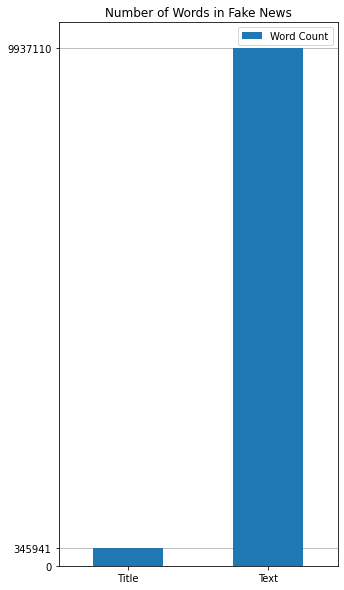

In [21]:
testStr1 = text.split()
testStr2 = allTextsFake.split()

fTitleCount = len(testStr1)
fTextCount = len(testStr2)

fCount = {'Title': fTitleCount, 'Text': fTextCount}

fakeNW = pd.DataFrame.from_dict(fCount, orient='index', columns=['Word Count'])

yticks = [0]
yticks.append(fTitleCount)
yticks.append(fTextCount)
ax = fakeNW.plot.bar(rot=0, figsize=(5,10), zorder=3)
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.set_yticks(yticks)
ax.yaxis.grid(True)
plt.title('Number of Words in Fake News')
plt.show()

*Για το αρχείο True*

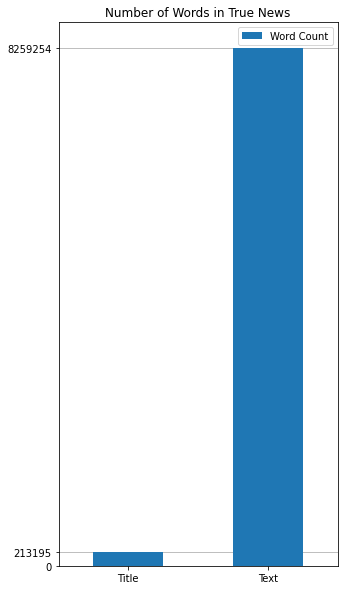

In [22]:
testStr3 = text2.split()
testStr4 = allTextsTrue.split()

tTitleCount = len(testStr3)
tTextCount = len(testStr4)
tCount = {'Title': tTitleCount, 'Text': tTextCount}
trueNW = pd.DataFrame.from_dict(tCount, orient='index', columns=['Word Count'])

yticks = [0]
yticks.append(tTitleCount)
yticks.append(tTextCount)
ax = trueNW.plot.bar(rot=0, figsize=(5,10), zorder=3)
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.set_yticks(yticks)
ax.yaxis.grid(True)
plt.title('Number of Words in True News')
plt.show()

*δ. Επαναλάβετε το προηγούμενο ερώτημα αφαιρώντας τα stopwords.*

*Για το αρχείο Fake*

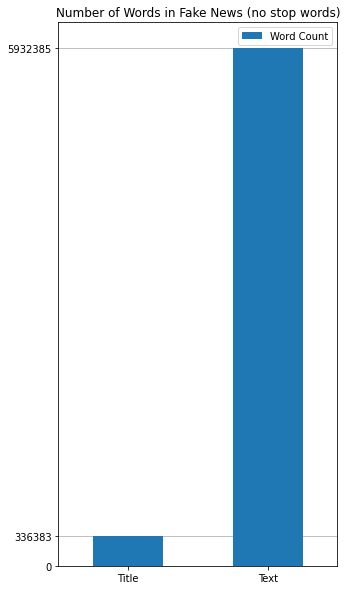

In [23]:
titleSW = []
textSW = []
for word in testStr1:
    if word not in stop_words:
        titleSW.append(word)
for word in testStr2:
    if word not in stop_words:
        textSW.append(word)

noSWcountF1 = len(titleSW)
noSWcountF2 = len(textSW)
fakeNoSW = {'Title': noSWcountF1, 'Text': noSWcountF2}

fake_pdNS = pd.DataFrame.from_dict(fakeNoSW, orient='index', columns=['Word Count'])

yticks = [0]
yticks.append(noSWcountF1)
yticks.append(noSWcountF2)

ax = fake_pdNS.plot.bar(rot=0, figsize=(5,10), zorder=3)
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.set_yticks(yticks)
ax.yaxis.grid(True)
plt.title('Number of Words in Fake News (no stop words)')
plt.show()

*Για το αρχείο True*

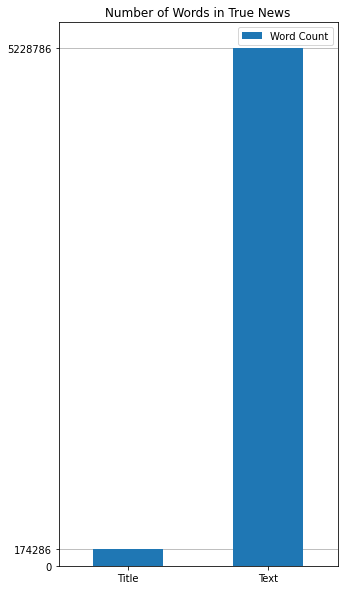

In [24]:
titleSW2 = []
textSW2 = []
for word in testStr3:
    if word not in stop_words:
        titleSW2.append(word)
for word in testStr4:
    if word not in stop_words:
        textSW2.append(word)
        
noSWcountT1 = len(titleSW2)
noSWcountT2 = len(textSW2)
trueNoSW = {'Title': noSWcountT1, 'Text': noSWcountT2}

true_pdNW = pd.DataFrame.from_dict(trueNoSW, orient='index', columns=['Word Count'])

yticks = [0]
yticks.append(noSWcountT1)
yticks.append(noSWcountT2)

ax = true_pdNW.plot.bar(rot=0, figsize=(5,10), zorder=3)
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.set_yticks(yticks)
ax.yaxis.grid(True)

plt.title('Number of Words in True News')
plt.show()

*ε. Ποια είναι τα πιο συχνά (πχ 10 ή 20) bigrams στους τίτλους και ποια στο κυρίως
άρθρο;*

Για Fake News

*Στα wordclouds παρακάτω επιλέξαμε να εμφανίζονται τα bigrams κατά προτίμηση οριζόντια και ορίσαμε ελάχιστο μέγεθος φόντου μεγαλύτερο από το default, έτσι ώστε να διακρίνονται καλύτερα τα 10 έως 20 πιο συχνά bigrams*

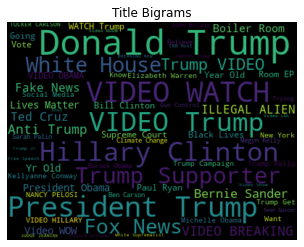

In [51]:
wordcloudE = WordCloud(height=300, prefer_horizontal=1.1, min_font_size=6, stopwords=stop_words, min_word_length=2, collocation_threshold=1).generate(text)
plt.imshow(wordcloudE, interpolation='bilinear')
plt.axis("off")
plt.title('Title Bigrams')
plt.show()

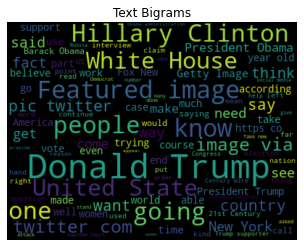

In [26]:
wordcloudEtext = WordCloud(height=300, prefer_horizontal=1.1, min_font_size=6, stopwords=stop_words, min_word_length=2, collocation_threshold=1).generate(allTextsFake)
plt.imshow(wordcloudEtext, interpolation='bilinear')
plt.axis("off")
plt.title('Text Bigrams')
plt.show()

Για True News

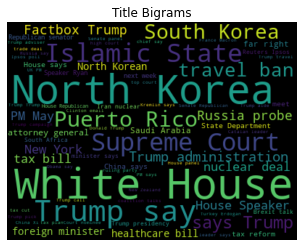

In [27]:
wordcloudE2 = WordCloud(height=300, prefer_horizontal=1.1, min_font_size=6, stopwords=stop_words, min_word_length=2, collocation_threshold=1).generate(text2)
plt.imshow(wordcloudE2, interpolation='bilinear')
plt.axis("off")
plt.title('Title Bigrams')
plt.show()

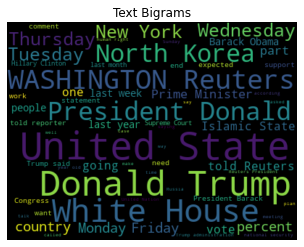

In [28]:
wordcloudEtext2 = WordCloud(height=300, prefer_horizontal=1.1, min_font_size=6, stopwords=stop_words, min_word_length=2, collocation_threshold=1).generate(allTextsTrue)
plt.imshow(wordcloudEtext2, interpolation='bilinear')
plt.axis("off")
plt.title('Text Bigrams')
plt.show()

# **3. Δημιουργία συνόλου εκμάθησης και δοκιμής**

***Προετοιμασία των train και test***

*Επιλέξαμε να κρατήσουμε το 80% των συνολικών εγγραφών των dataframes για το train και το υπόλοιπο 20% για τα test*

In [31]:
fakePercent = int(0.8 * len(fakeNN.index))
truePercent = int(0.8 * len(trueNN.index))
trainFake = fakeNN[:fakePercent]
testFake = fakeNN[fakePercent+1:]
trainTrue = trueNN[:truePercent]
testTrue = trueNN[truePercent+1:]

*Προσθέσαμε στα dataframes ένα καινούριο column με όνομα label στο οποίο η τιμή 0 αντιστοιχεί σε fake news και η τιμή 1 σε true*

In [32]:
trainFake.insert(4, 'label', 0)
testFake.insert(4, 'label', 0)

In [33]:
trainTrue.insert(4, 'label', 1)
testTrue.insert(4, 'label', 1)

*Συνενώσαμε τα dataframes των fake και true σε ένα dataframe για train και ένα για test και τα αποθηκεύσαμε σε csv αρχεία.*

In [34]:
trainDF = trainFake.append(trainTrue, ignore_index=True)
trainDF.to_csv('train.csv')
testDF = testFake.append(testTrue, ignore_index=True)
testDF.to_csv('test.csv')

*Διαβάσαμε από τα αρχεία τα δεδομένα και τα αποθηκεύσαμε σε δύο καινούρια dataframes*

In [35]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

*Διαγράψαμε τη στήλη Unnamed 0 που δε μας χρειάζεται*

In [36]:
train = train.drop(columns=['Unnamed: 0'])
test = test.drop(columns=['Unnamed: 0'])

*Δημιουργήσαμε μία νέα στήλη με όνομα concat η οποία περιέχει την ένωση των στηλών title, subject και text έτσι ώστε να έχουμε μια πιο αντιπροσωπευτική εικόνα για το κάθε άρθρο, πράγμα το οποίο θα μας βοηθήσει μετέπειτα στο classification*

In [37]:
train['concat'] = train['title'] + ' ' + train['subject'] + ' ' + train['text']
test['concat'] = test['title'] + ' ' + test['subject'] + ' ' + test['text']

*Ανακατέψαμε τις εγγραφές για να έχουμε καλύτερα αποτελέσματα*

In [38]:
train = train.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)

*Παρακάτω κάναμε καθαρισμό κειμένου στη στήλη concat αφαιρώντας τα σύμβολα και σημεία στήξης, τους μονούς χαρακτήρες και μετατρέποντας όλα τα γράμματα από κεφαλαία σε μικρά.*

In [39]:
tokenizer = nltk.RegexpTokenizer(r"\w+")
for index, data in train.iterrows():
    cleanText = tokenizer.tokenize(data[5])
    tempStr = ""
    for word in cleanText:
        if len(word) > 1:
            tempStr = tempStr + ' ' + word.lower()
    train.iat[index, 5] = tempStr

In [40]:
for index, data in test.iterrows():
    cleanText = tokenizer.tokenize(data[5])
    tempStr = ""
    for word in cleanText:
        if len(word) > 1:
            tempStr = tempStr + ' ' + word.lower()
    test.iat[index, 5] = tempStr

# **Υλοποίηση Κατηγοριοποίησης (Classification)**


# BoW και TF-IDF

*Επιλέξαμε να χρησιμοποιήσουμε μέγιστο αριθμό features ίσο με 300, επειδή παρατηρήσαμε ότι στην προηγούμενη εργασία μας είχε επιφέρει καλά αποτελέσματα και αφαιρέσαμε τα stop words. Ο vectorizer εφαρμόστηκε στη στήλη concat, την οποία έχουμε επεξεργαστεί παραπάνω*

BoW counts

In [41]:
vectorizer = CountVectorizer(max_features=300, stop_words=stop_words)
trainBoW = vectorizer.fit_transform(train['concat'])
testBoW = vectorizer.fit_transform(test['concat'])

TF-IDF

In [42]:
vectorizer = TfidfVectorizer(max_features=300, stop_words=stop_words)
trainTFIDF = vectorizer.fit_transform(train['concat'])
testTFIDF = vectorizer.fit_transform(test['concat'])

**Logistic Regression**

In [43]:
model = LogisticRegression(max_iter=100000)
model.fit(trainBoW,train['label'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [44]:
accuracy = model.score(testBoW, test['label'])
print("BoW:", accuracy)

BoW: 0.9513308831718454


In [45]:
predicts = model.predict(testBoW)
print("BoW accuracy score:", accuracy_score(test['label'], predicts))

BoW accuracy score: 0.9513308831718454


In [46]:
print("BoW f1 score:", f1_score(test['label'], predicts))

BoW f1 score: 0.9474443776307877


In [47]:
model.fit(trainTFIDF, train['label'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [48]:
accuracy = model.score(testTFIDF, test['label'])
print("TF-IDF:", accuracy)

TF-IDF: 0.7703530459962133


In [49]:
predicts = model.predict(testTFIDF)
print("TF-IDF accuracy score:", accuracy_score(test['label'], predicts))

TF-IDF accuracy score: 0.7703530459962133


In [50]:
print("TF-IDF f1 score:", f1_score(test['label'], predicts))

TF-IDF f1 score: 0.7129732739420935


**Naive Bayes**

*Στη μέθοδο της κατηγοριοποίησης Naive Bayes χρειάστηκε να μετατρέψουμε τα matrices των Vectors σε πίνακα της παρακάτω μορφής για να μπορέσουν να περαστούν σωστά ως ορίσματα στην συγκεκριμένη μέθοδο. Επίσης από τους διάφορους τύπους της Naive Bayes επιλέξαμε να χρησιμοποιήσουμε την Gaussian.*

In [52]:
trainArrayBoW = trainBoW.toarray()
trainArrayTFIDF = trainTFIDF.toarray()
testArrayBoW = testBoW.toarray()
testArrayTFIDF = testTFIDF.toarray()

In [53]:
gnb = GaussianNB()
gnb.fit(trainArrayBoW, train['label'])


GaussianNB(priors=None, var_smoothing=1e-09)

In [54]:
predicts = gnb.predict(testArrayBoW)
accuracy = gnb.score(testArrayBoW, test['label'])
print("BoW:", accuracy)

BoW: 0.8348368415191001


In [55]:
print("BoW accuracy score:", accuracy_score(test['label'], predicts))

BoW accuracy score: 0.8348368415191001


In [56]:
print("BoW f1 score:", f1_score(test['label'], predicts))

BoW f1 score: 0.8524231266792716


In [57]:
gnb.fit(trainArrayTFIDF, train['label'])

GaussianNB(priors=None, var_smoothing=1e-09)

In [58]:
predicts = gnb.predict(testArrayTFIDF)
accuracy = gnb.score(testArrayTFIDF, test['label'])
print("TF-IDF:", accuracy)

TF-IDF: 0.885733377881724


In [59]:
print("TF-IDF accuracy score:",accuracy_score(test['label'], predicts))

TF-IDF accuracy score: 0.885733377881724


In [60]:
print("TF-IDF f1 score:", f1_score(test['label'], predicts))

TF-IDF f1 score: 0.8930358632193495


**Support Vector Machines**

In [61]:
svmodel = svm.SVC()
svmodel.fit(trainBoW, train['label'])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [62]:
predicts = svmodel.predict(testBoW)
print("BoW accuracy score:", accuracy_score(test['label'], predicts))

BoW accuracy score: 0.7574340126962913


In [63]:
print("BoW f1 score:", f1_score(test['label'], predicts))

BoW f1 score: 0.6650261458012918


In [64]:
svmodel.fit(trainTFIDF, train['label'])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [65]:
predicts = svmodel.predict(testTFIDF)
print("TF-IDF accuracy score:", accuracy_score(test['label'], predicts))

TF-IDF accuracy score: 0.7464082860006682


In [66]:
print("TF-IDF f1 score:", f1_score(test['label'], predicts))

TF-IDF f1 score: 0.6570266606416628


**Random Forests**

In [67]:
rf = RandomForestClassifier()
rf.fit(trainBoW, train['label'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [68]:
predicts = rf.predict(testBoW)
print("BoW accuracy score:", accuracy_score(test['label'], predicts))

BoW accuracy score: 0.920369751642722


In [69]:
print("BoW f1 score:", f1_score(test['label'], predicts))

BoW f1 score: 0.911586496846791


In [70]:
rf.fit(trainTFIDF, train['label'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [71]:
predicts = rf.predict(testTFIDF)
print("TF-IDF accuracy score:", accuracy_score(test['label'], predicts))

TF-IDF accuracy score: 0.8480899877491925


In [72]:
print("TF-IDF f1 score:", f1_score(test['label'], predicts))

TF-IDF f1 score: 0.8133041335888311


# Word2Vec

*Διασπάσαμε τη στήλη concat σε tokens αφαιρώντας τα stop words*

In [73]:
trainTokens = [text.lower().split() for text in train['concat']]
testTokens = [text.lower().split() for text in test['concat']]

In [74]:
for sentence in trainTokens:
    for word in sentence:
        if word in stop_words:
            sentence.remove(word)

for sentence in testTokens:
    for word in sentence:
        if word in stop_words:
            sentence.remove(word)

*Δημιουργήσαμε Vectors μεγέθους 100 από τα tokens και παρακάτω χτίσαμε το λεξιλόγιο και κάναμε train το μοντέλο*

In [75]:
train_w2v = Word2Vec(trainTokens, vector_size=100, seed=32, negative=5, sg=0, min_count=1, window=1)
test_w2v = Word2Vec(testTokens, vector_size=100, seed=32, negative=5, sg=0, min_count=1, window=1)

In [77]:
train_w2v.build_vocab(trainTokens)
train_w2v.train(trainTokens, total_examples=train_w2v.corpus_count, epochs=5)

test_w2v.build_vocab(testTokens)
test_w2v.train(testTokens, total_examples=test_w2v.corpus_count, epochs=5)

(13319938, 13995875)

*Αποθηκέυσαμε τα λεξιλόγια των μοντέλων σε μεταβλητές*

In [78]:
trainVec = train_w2v.wv
testVec = test_w2v.wv

*Για κάθε row της στήλης concat, πήραμε το άθροισμα των Vectors των λέξεων που περιέχονται στο αντίστοιχο κείμενο και διαρώντας με τον αριθμό των αντίστοιχων λέξεων πήραμε ένα Vector ίδιου μεγέθους της μέσης τιμής. Έτσι το κάθε Vector έχει την αντίστοιχη τιμή ολόκληρου του κειμένου.*

In [79]:
iteration = 0
trainMeanVec = {}
for row in train['concat']:
    arr = np.zeros(100)
    found = 0
    for i in row.split():
        if i in trainVec.index_to_key:
            found += 1
            arr = np.add(arr,trainVec[i])
    meanArr = arr / found
    trainMeanVec[iteration] = meanArr
    iteration += 1

In [80]:
iteration = 0
testMeanVec = {}
for row in test['concat']:
    arr = np.zeros(100)
    found = 0
    for i in row.split():
        if i in testVec.index_to_key:
            found += 1
            arr = np.add(arr,testVec[i])
    meanArr = arr / found
    testMeanVec[iteration] = meanArr
    iteration += 1

*Μετατρέψαμε σε πίνακες τα παραπάνω για να μπορέσουμε να τα χρησιμοποιήσουμε σωστά στα μοντέλα παρακάτω*

In [81]:
trainMeanArray = np.array([trainMeanVec[i] for i in trainMeanVec])
testMeanArray = np.array([testMeanVec[i] for i in testMeanVec])

**Logistic Regression**

In [82]:
model = LogisticRegression(max_iter=100000)
model.fit(trainMeanArray, train['label'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [83]:
predicts = model.predict(testMeanArray)
print("accuracy score:", accuracy_score(test['label'], predicts))

accuracy score: 0.5394810112484687


In [84]:
print("f1 score:", f1_score(test['label'], predicts))

f1 score: 0.40460763138948885


**Naive Bayes**

In [85]:
gnb = GaussianNB()
gnb.fit(trainMeanArray, train['label'])

GaussianNB(priors=None, var_smoothing=1e-09)

In [86]:
predicts = gnb.predict(testMeanArray)
print("accuracy score:", accuracy_score(test['label'], predicts))

accuracy score: 0.49448713665218846


In [87]:
print("f1 score:", f1_score(test['label'], predicts))

f1 score: 0.6536436474628005


**Support Vector Machines**

In [88]:
svmodel = svm.SVC()
svmodel.fit(trainMeanArray, train['label'])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [89]:
predicts = svmodel.predict(testMeanArray)
print("accuracy score:", accuracy_score(test['label'], predicts))

accuracy score: 0.5193228644615213


In [90]:
print("f1 score:", f1_score(test['label'], predicts))

f1 score: 0.16421378776142526


**Random Forests**

In [91]:
rf = RandomForestClassifier()
rf.fit(trainMeanArray, train['label'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [92]:
predicts = rf.predict(testMeanArray)
print("accuracy score:", accuracy_score(test['label'], predicts))

accuracy score: 0.5327987526450607


In [93]:
print("f1 score:", f1_score(test['label'], predicts))

f1 score: 0.1053529537214758
